In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

In [3]:
font = {'size'   : 1}

mpl.rcParams["font.size"] = 18

In [2]:
data = list()
tools=["optitype",'T1K','hlahd',"arcas",'hisat',"seq2hla","phlat","hlaforest","hlavbseq",'hlaminer']
#datasets=["1","d2","d3","d4","d5","d6"]
for t in tools:
    total = []
    for d in range(1,7):
        gs=pd.read_csv("../datasets/"+str(d)+"_gs.csv")
        pre=pd.read_csv("../results/standard/"+str(t)+"_d"+str(d)+".csv")
        
        for gene in ["A", "B", "C", "DQB1", "DRB1"]:
            target = gene + ".1"
            if (target not in pre.columns):
                continue
            pre[target].fillna(pre[gene], inplace=True)
            
            
        ret=compute_matches(pre,gs)
        print(t,"d"+str(d),ret)
        total.append(ret)
    data.append(total)

optitype d1 ([10, 0], [33, 0], [2897, 0], [0, 1960])
optitype d2 ([0, 0], [0, 0], [0, 0], [172, 0])
optitype d3 ([8, 0], [10, 0], [282, 0], [0, 0])
optitype d4 ([0, 0], [0, 0], [0, 0], [28, 0])
optitype d5 ([0, 0], [0, 0], [0, 8], [0, 0])
optitype d6 ([0, 4], [0, 0], [0, 4], [0, 0])
T1K d1 ([13, 7], [43, 92], [2884, 1861], [0, 0])
T1K d2 ([0, 4], [0, 5], [0, 163], [0, 0])
T1K d3 ([12, 0], [80, 0], [208, 0], [0, 0])
T1K d4 ([0, 9], [0, 1], [0, 18], [0, 0])
T1K d5 ([0, 0], [0, 0], [0, 8], [0, 0])
T1K d6 ([0, 4], [0, 0], [0, 4], [0, 0])
hlahd d1 ([34, 15], [104, 82], [2802, 1863], [0, 0])
hlahd d2 ([0, 4], [0, 5], [0, 163], [0, 0])
hlahd d3 ([15, 0], [90, 0], [195, 0], [0, 0])
hlahd d4 ([0, 6], [0, 1], [0, 11], [0, 10])
hlahd d5 ([0, 0], [0, 0], [0, 8], [0, 0])
hlahd d6 ([0, 4], [0, 0], [0, 4], [0, 0])
arcas d1 ([38, 6], [144, 127], [2758, 1827], [0, 0])
arcas d2 ([0, 4], [0, 5], [0, 163], [0, 0])
arcas d3 ([9, 0], [88, 0], [203, 0], [0, 0])
arcas d4 ([0, 0], [0, 0], [0, 4], [0, 24])
arca

In [17]:
# Calculating Class I and Class II Accuracy -- NO CALLS INCLUDED
data = np.array(data)

classIresults = []
classIIresults = []
allresults = []

for tool in data:
    r = np.sum(np.array(tool),axis=0)
    allresults.append(r[:,0]+r[:,1])
    classIresults.append(r[:,0])
    classIIresults.append(r[:,1])

# normalizing accuracies to 1
classIresults = np.array(classIresults)
row_sums = classIresults.sum(axis=1)
classIresults = classIresults / row_sums[:, np.newaxis]


classIIresults = np.array(classIIresults)
row_sums = classIIresults.sum(axis=1)
classIIresults = classIIresults / row_sums[:, np.newaxis]

allresults = np.array(allresults)
row_sums = allresults.sum(axis=1)
allresults = allresults / row_sums[:, np.newaxis]


print(classIresults)
print(classIIresults)
print(allresults)



[[0.00523256 0.0125     0.92412791 0.05813953]
 [0.00771605 0.03796296 0.95432099 0.        ]
 [0.01512346 0.05987654 0.925      0.        ]
 [0.01450617 0.07160494 0.91388889 0.        ]
 [0.02932099 0.03796296 0.93271605 0.        ]
 [0.01510481 0.03976572 0.94389642 0.00123305]
 [0.03042409 0.09557468 0.86969883 0.0043024 ]
 [0.03452528 0.16368681 0.80055487 0.00123305]
 [0.0974106  0.07552404 0.82583231 0.00123305]
 [0.79753086 0.13271605 0.06296296 0.00679012]]
[[2.02429150e-03 0.00000000e+00 6.07287449e-03 9.91902834e-01]
 [1.10294118e-02 4.50367647e-02 9.43933824e-01 0.00000000e+00]
 [1.33272059e-02 4.04411765e-02 9.41636029e-01 4.59558824e-03]
 [5.97426471e-03 6.06617647e-02 9.22334559e-01 1.10294118e-02]
 [2.34375000e-02 4.91727941e-02 9.23713235e-01 3.67647059e-03]
 [8.93186004e-02 9.85267035e-02 8.12154696e-01 0.00000000e+00]
 [1.94727105e-01 6.93802035e-02 7.35892692e-01 0.00000000e+00]
 [2.71639042e-02 1.20626151e-01 8.52209945e-01 0.00000000e+00]
 [9.10220994e-01 1.795580

       Tools      zero  two dig accuracy  four dig accuracy
0   optitype  0.004062          0.007939           0.589180
1        T1K  0.009047          0.040805           0.950148
2      hlahd  0.014402          0.052068           0.931684
3      arcas  0.011078          0.067208           0.917282
4      hisat  0.026957          0.042467           0.929099
5    seq2hla  0.044867          0.063331           0.891064
6      phlat  0.096012          0.085118           0.816285
7  hlaforest  0.031573          0.146418           0.821270
8   hlavbseq  0.423375          0.052437           0.523080
9   hlaminer  0.741876          0.165990           0.079025


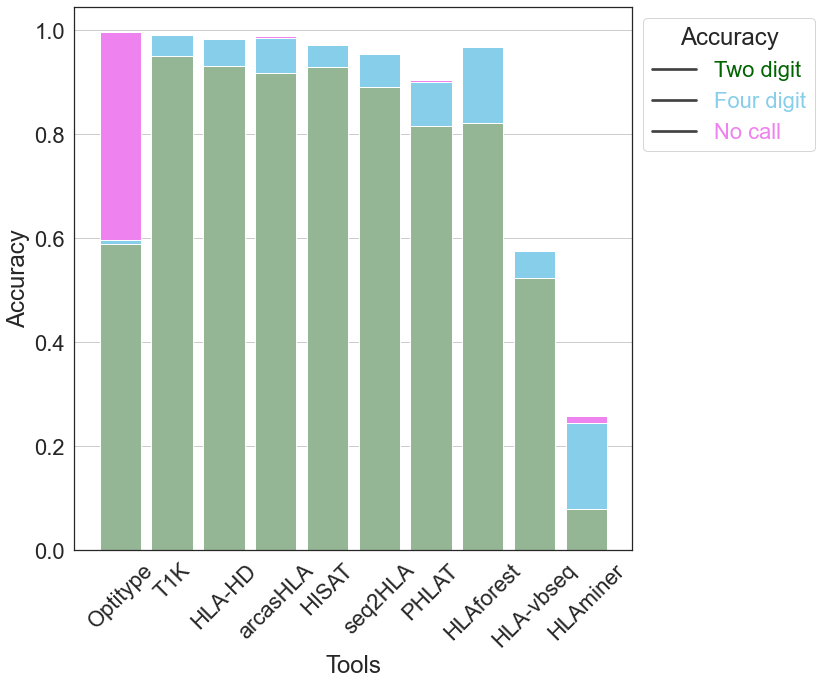

In [22]:
# combined accuracy bar plot (not split by class 1 and class 2) -- NO CALLS INCLUDED

combined_df = pd.DataFrame({'Tools': tools, 'zero': allresults[:, 0],'two dig accuracy': allresults[:, 1],'four dig accuracy': allresults[:, 2]})
print(combined_df)

sns.set_context("paper")
sns.color_palette("pastel")
sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=2)
sns.set_style("white")
plt.grid()


my_order=["Optitype","T1K","HLA-HD","arcasHLA","HISAT","seq2HLA","PHLAT","HLAforest","HLA-vbseq",'HLAminer']

ax = sns.barplot(data=combined_df,x='Tools',y='four dig accuracy',color = "darkseagreen")
ax.bar(tools,allresults[:, 1],bottom=allresults[:, 2], color='skyblue')
ax.bar(tools,allresults[:, 3],bottom=allresults[:, 2]+allresults[:, 1], color='violet')


ax.set_xticklabels(labels=my_order, rotation = 45)
ax.set_ylabel("Accuracy")
plt.legend(title='Accuracy', loc='upper left', labels=['Two digit', 'Four digit','No call'], labelcolor=['darkgreen','skyblue','violet'],bbox_to_anchor=(1,1))

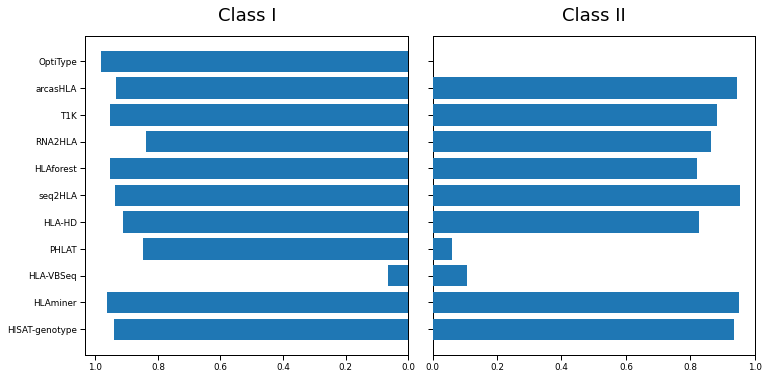

In [25]:
# class1 vs class2 barplot for 4 dig accuracy

index = ["OptiType","arcasHLA","T1K","RNA2HLA","HLAforest","seq2HLA","HLA-HD","PHLAT","HLA-VBSeq","HLAminer", "HISAT-genotype"]
title0 = 'Class I'
title1 = 'Class II'

fourdig_I = classIresults[:,2]
fourdig_II = classIIresults[:,2]

fig, axes = plt.subplots(figsize=(10,5),  ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, fourdig_I, align='center',zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15)
axes[1].barh(index, fourdig_II, align='center', zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15)


axes[0].invert_xaxis() 
plt.gca().invert_yaxis()

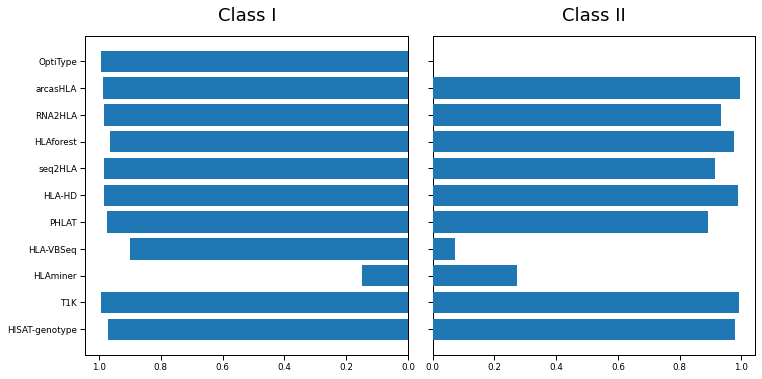

In [26]:
# class1 vs class2 barplot for 2 dig accuracy


index = ["OptiType","arcasHLA","RNA2HLA","HLAforest","seq2HLA","HLA-HD","PHLAT","HLA-VBSeq","HLAminer","T1K", "HISAT-genotype"]
title0 = 'Class I'
title1 = 'Class II'
twodig_I = classIresults[:,1]+classIresults[:,2]
twodig_II = classIIresults[:,1]+classIIresults[:,2]


fig, axes = plt.subplots(figsize=(10,5),  ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, twodig_I, align='center',zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15)
axes[1].barh(index, twodig_II, align='center', zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15)


axes[0].invert_xaxis() 
plt.gca().invert_yaxis()

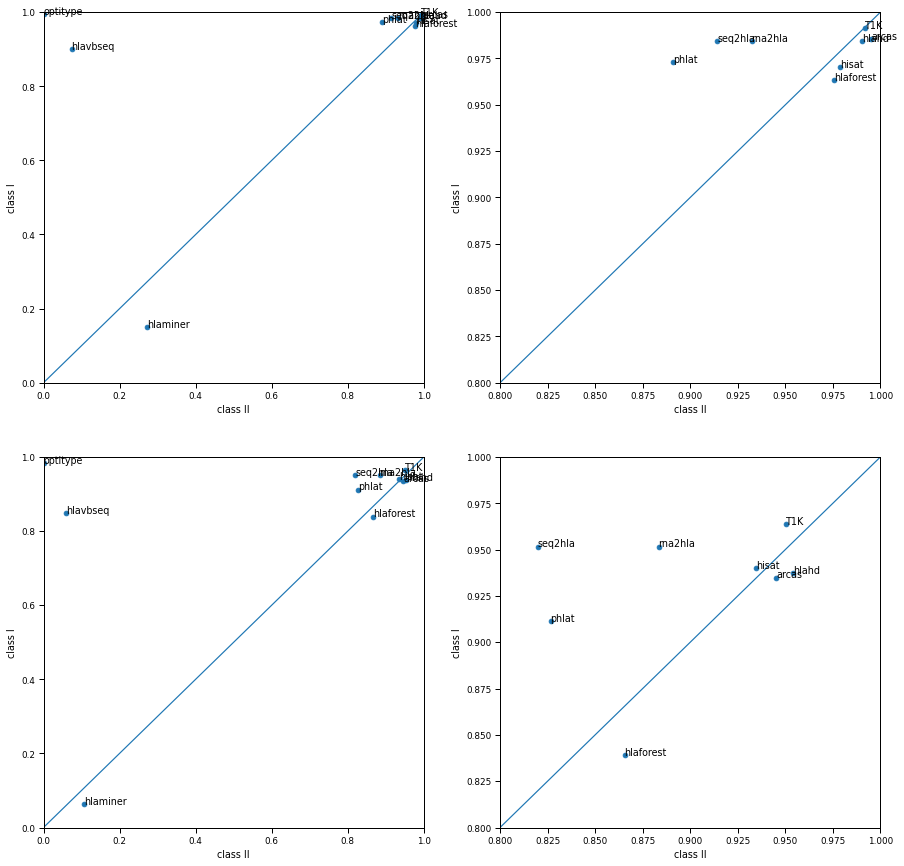

In [27]:
# class1 vs class2 scatterplot for 2 and 4 dig accuracy OLD


fig, ax = plt.subplots(2, 2,figsize=(15, 15))


ax[0][0].scatter(twodig_II,twodig_I)
for i, txt in enumerate(tools):
    ax[0][0].annotate(txt, (twodig_II[i], twodig_I[i]))
ax[0][0].set_xlim([0,1])
ax[0][0].set_ylim([0,1])
ax[0][0].set_xlabel("class II")
ax[0][0].set_ylabel("class I")
ax[0][0].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


ax[0][1].scatter(twodig_II,twodig_I)
for i, txt in enumerate(tools):
    ax[0][1].annotate(txt, (twodig_II[i], twodig_I[i]))
ax[0][1].set_xlim([0.8,1])
ax[0][1].set_ylim([0.8,1])
ax[0][1].set_xlabel("class II")
ax[0][1].set_ylabel("class I")
ax[0][1].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


ax[1][0].scatter(fourdig_II,fourdig_I)
for i, txt in enumerate(tools):
    ax[1][0].annotate(txt, (fourdig_II[i], fourdig_I[i]))
ax[1][0].set_xlim([0,1])
ax[1][0].set_ylim([0,1])
ax[1][0].set_xlabel("class II")
ax[1][0].set_ylabel("class I")
ax[1][0].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


ax[1][1].scatter(fourdig_II,fourdig_I)
for i, txt in enumerate(tools):
    ax[1][1].annotate(txt, (fourdig_II[i], fourdig_I[i]))
ax[1][1].set_xlim([0.8,1])
ax[1][1].set_ylim([0.8,1])
ax[1][1].set_xlabel("class II")
ax[1][1].set_ylabel("class I")
ax[1][1].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))


In [28]:
labels=["OptiType","arcasHLA","RNA2HLA","HLAforest","seq2HLA","HLA-HD","PHLAT","HLA-VBSeq","HLAminer","T1K", "HISAT-genotype"]

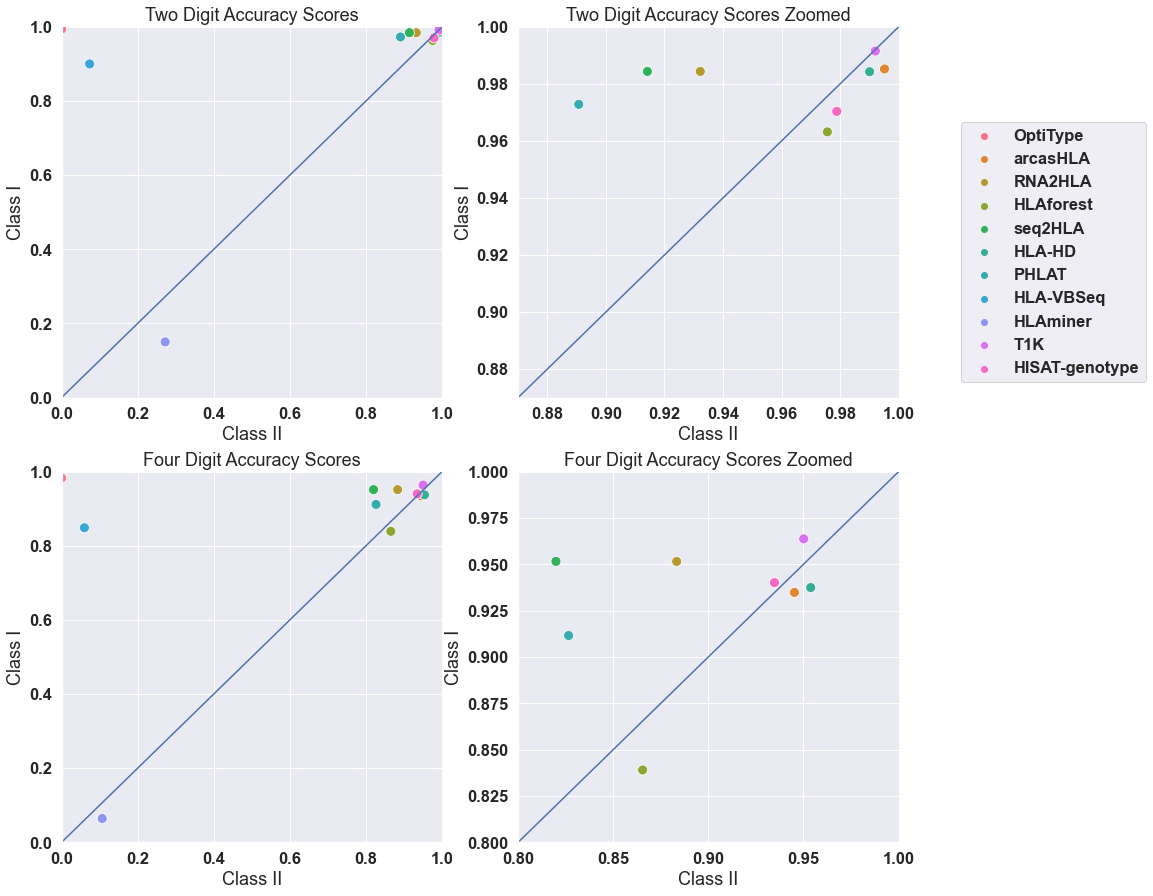

In [95]:
# class1 vs class2 scatterplot for 2 and 4 dig accuracy CURRENT


sns.set_context("paper")
sns.color_palette("pastel")
sns.set(font_scale=1.5)


fig, ax = plt.subplots(2, 2,figsize=(15, 15))
sns.scatterplot(ax=ax[0][0],x=twodig_II, y=twodig_I,hue=labels,legend=False, s=100)
#for i, txt in enumerate(labels):
#    ax[0][0].annotate(txt, (twodig_II[i], twodig_I[i]))
ax[0][0].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))
ax[0][0].set_xlim([0,1])
ax[0][0].set_ylim([0,1])
ax[0][0].set_xlabel("Class II")
ax[0][0].set_ylabel("Class I")
ax[0][0].set(title='Two Digit Accuracy Scores')

sns.scatterplot(ax=ax[0][1],x=twodig_II, y=twodig_I,hue=labels,legend=False, s=100)
# for i, txt in enumerate(labels):
#     ax[0][1].annotate(txt, (twodig_II[i], twodig_I[i]))
ax[0][1].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))
ax[0][1].set_xlim([0.87,1])
ax[0][1].set_ylim([0.87,1])
ax[0][1].set_xlabel("Class II")
ax[0][1].set_ylabel("Class I")
ax[0][1].set(title='Two Digit Accuracy Scores Zoomed')

sns.scatterplot(ax=ax[1][0],x=fourdig_II, y=fourdig_I,hue=labels,legend=False, s=100)
#for i, txt in enumerate(labels):
#    ax[1][0].annotate(txt, (fourdig_II[i], fourdig_I[i]))
ax[1][0].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))
ax[1][0].set_xlim([0,1])
ax[1][0].set_ylim([0,1])
ax[1][0].set_xlabel("Class II")
ax[1][0].set_ylabel("Class I")
ax[1][0].set(title='Four Digit Accuracy Scores')

sns.scatterplot(ax=ax[1][1],x=fourdig_II, y=fourdig_I,hue=labels, s=100)
plt.legend([],[], frameon=False)
# for i, txt in enumerate(labels):
#     ax[1][1].annotate(txt, (fourdig_II[i], fourdig_I[i]))
ax[1][1].plot(np.linspace(0, 1, 100),np.linspace(0, 1, 100))
ax[1][1].set_xlim([0.8,1])
ax[1][1].set_ylim([0.8,1])
ax[1][1].set_xlabel("Class II")
ax[1][1].set_ylabel("Class I")
ax[1][1].set(title='Four Digit Accuracy Scores Zoomed')
#handles, labels = ax[1][1].get_legend_handles_labels()

fig.legend(*ax[1][1].get_legend_handles_labels(), loc="upper left",ncol=1,bbox_to_anchor=(0.95,0.8))
sns.despine()